In [2]:
import qiskit
import random
import scipy.linalg
import math
import csv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
from operator import itemgetter
from scipy.optimize import minimize
from qiskit import *

m=int(input("enter number of layers"))
#initialise graph
seed=9854
G = nx.random_regular_graph(3, 6, seed=seed)

#cost operator
def append_zz_term(qc, q1, q2, gamma):
    qc.cx(q1,q2)
    qc.rz(2*gamma, q2)
    qc.cx(q1,q2)

def get_cost_operator_circuit(G, gamma):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for i, j in G.edges():
        append_zz_term(qc, i, j, gamma)
    return qc
qc = get_cost_operator_circuit(G, np.pi / 3)

#mixer operator
def append_x_term(qc, q1, beta):
    qc.rx(2*beta, q1)

def get_mixer_operator_circuit(G, beta):
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    for n in G.nodes():
        append_x_term(qc, n, beta)
    return qc
qc = get_mixer_operator_circuit(G, np.pi/3)

#QAOA CIRCUIT
def get_qaoa_circuit(G, beta, gamma):
    assert(len(beta) == len(gamma))
    p = len(beta) # infering number of QAOA steps from the parameters passed
    N = G.number_of_nodes()
    qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
    qc.h(range(N))
    # second, apply p alternating operators
    for i in range(p):
        qc += get_cost_operator_circuit(G,gamma[i])
        qc += get_mixer_operator_circuit(G,beta[i])
    # finally, do not forget to measure the result!
    qc.barrier(range(N))
    qc.measure(range(N), range(N))
    return qc
qc = get_qaoa_circuit(G,[np.pi/3], [np.pi/2])

#to fix qiskit qubit ordering
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()

#defining maxcut values and stuff
def maxcut_obj(x,G):
    cut = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            # the edge is cut
            cut -= 1
    return cut

def compute_maxcut_energy(counts, G):
    energy = 0
    total_counts = 0
    for meas, meas_count in counts.items():
        obj_for_meas = maxcut_obj(meas, G)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return energy / total_counts

#the circuit put inside a blackbox
def get_black_box_objective(G,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        beta = theta[:p]
        gamma = theta[p:]
        qc = get_qaoa_circuit(G,beta, gamma)
        counts = execute(qc, backend, seed_simulator=10).result().get_counts()
        # return the energy
        return compute_maxcut_energy(invert_counts(counts), G)
    return f

entropy=[]
layers=[]
entropy_data=[]
    
for p in range(1, m):
    
    entropy_data=[]
    for c in range(1, 101):
        #the optimisation part but randomised
        obj = get_black_box_objective(G, p)
    #random.seed(69)

        my_array = []

        for i in range(p):
            my_array.append(random.uniform(0, np.pi))

        for i in range(p):
            my_array.append(random.uniform(0, 2*np.pi))

    
        init_point = my_array
        res_sample = minimize(obj, init_point, method='COBYLA', options={'maxiter':0, 'disp': True})
        optimal_theta = res_sample['x']
        qc = get_qaoa_circuit(G, optimal_theta[:p], optimal_theta[p:])
        counts = invert_counts(execute(qc, backend).result().get_counts())

    # for state vector formalism
        def state_num2str(basis_state_as_num, nqubits):
            return '{0:b}'.format(basis_state_as_num).zfill(nqubits)

        def state_str2num(basis_state_as_str):
            return int(basis_state_as_str, 2)

        def state_reverse(basis_state_as_num, nqubits):
            basis_state_as_str = state_num2str(basis_state_as_num, nqubits)
            new_str = basis_state_as_str[::-1]
            return state_str2num(new_str)

        def get_adjusted_state(state):
            nqubits = np.log2(state.shape[0])
            if nqubits % 1:
                raise ValueError("Input vector is not a valid statevector for qubits.")
            nqubits = int(nqubits)

            adjusted_state = np.zeros(2**nqubits, dtype=complex)
            for basis_state in range(2**nqubits):
                adjusted_state[state_reverse(basis_state, nqubits)] = state[basis_state]
            return adjusted_state
    
        def get_qaoa_circuit_sv(G, beta, gamma):
            assert(len(beta) == len(gamma))
            p = len(beta) # infering number of QAOA steps from the parameters passed
            N = G.number_of_nodes()
            qc = QuantumCircuit(N,N)
    # first, apply a layer of Hadamards
            qc.h(range(N))
    # second, apply p alternating operators
            for i in range(p):
                qc += get_cost_operator_circuit(G,gamma[i])
                qc += get_mixer_operator_circuit(G,beta[i])
    # no measurement in the end!
            return qc

        def state_to_ampl_counts(vec, eps=1e-15):
            qubit_dims = np.log2(vec.shape[0])
            if qubit_dims % 1:
                raise ValueError("Input vector is not a valid statevector for qubits.")
            qubit_dims = int(qubit_dims)
            counts = {}
            str_format = '0{}b'.format(qubit_dims)
            for kk in range(vec.shape[0]):
                val = vec[kk]
                if val.real**2+val.imag**2 > eps:
                    counts[format(kk, str_format)] = val
            return counts

        backend = Aer.get_backend('statevector_simulator')
        qc = get_qaoa_circuit_sv(G, optimal_theta[:p], optimal_theta[p:])
        sv = get_adjusted_state(execute(qc, backend).result().get_statevector())
        matrix=state_to_ampl_counts(sv)
    
        values = np.array(list(matrix.values()))
        output = np.reshape(values, (-1, 8)) # reshape the array and extract the real part
        truematrix = output.T
        U, D, V = scipy.linalg.svd(truematrix)
        precision = 4
        singular = [round(num, precision) for num in D]
        total = 0
        for num in singular:
            if num != 0:
                total += (-1)*(num**2 * math.log(num**2))
        entropy_data.append(total)
    entropyavg = sum(entropy_data) / len(entropy_data)
    entropy.append(entropyavg)
    layers.append(p)
    print("for", p, "entropy is", entropyavg)
    
    

    
file_path1 = 'entropy3reg6.csv'
with open(file_path1, mode='w', newline='') as file:
    writer = csv.writer(file)
    for value in entropy:
        writer.writerow([value])

file_path2 = 'layers3reg6.csv'
with open(file_path2, mode='w', newline='') as file:
    writer = csv.writer(file)
    for value in layers:
        writer.writerow([value])


enter number of layers51


C:\Users\prath\AppData\Local\Temp\ipykernel_11664\723918156.py:55: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_cost_operator_circuit(G,gamma[i])
C:\Users\prath\AppData\Local\Temp\ipykernel_11664\723918156.py:56: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_mixer_operator_circuit(G,beta[i])
C:\Users\prath\AppData\Local\Temp\ipykernel_11664\723918156.py:160: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  qc += get_cost_operator_circuit(

for 1 entropy is 1.0644778915484723
for 2 entropy is 1.1641822357322191
for 3 entropy is 1.295432427985923
for 4 entropy is 1.3152418450964343
for 5 entropy is 1.3465654613226425
for 6 entropy is 1.3531329463320036
for 7 entropy is 1.3257294024707582
for 8 entropy is 1.3279241256048244
for 9 entropy is 1.3365332197890163
for 10 entropy is 1.344963829949832
for 11 entropy is 1.3369652509978958
for 12 entropy is 1.3491781952048543
for 13 entropy is 1.3530506507137732
for 14 entropy is 1.3438035651267546
for 15 entropy is 1.3613728530712832
for 16 entropy is 1.3605819570194384
for 17 entropy is 1.348684846064773
for 18 entropy is 1.3488840895297278
for 19 entropy is 1.3423494482032563
for 20 entropy is 1.3612300629689997
for 21 entropy is 1.3716635285003962
for 22 entropy is 1.3333924314112724
for 23 entropy is 1.3429538623313402
for 24 entropy is 1.3478777451560915
for 25 entropy is 1.3487105734993412
for 26 entropy is 1.3661165495638203
for 27 entropy is 1.3567928544502665
for 28 entrop

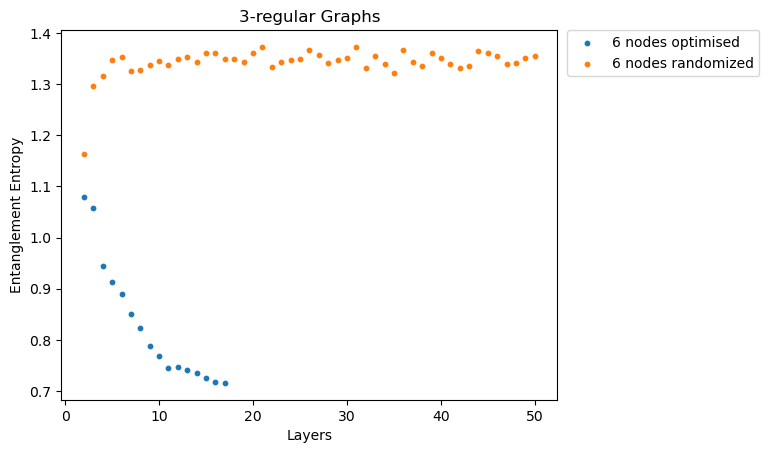

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
l = pd.read_csv('optimisedlayers3reg6.csv')
e = pd.read_csv('optimisedentropy3reg6.csv')
g = pd.read_csv('layers3reg6.csv')
f = pd.read_csv('entropy3reg6.csv')
plt.scatter(l,e, s=10, label='6 nodes optimised')
plt.scatter(g,f, s=10, label='6 nodes randomized')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0) 
plt.title("3-regular Graphs")
plt.xlabel("Layers")
plt.ylabel("Entanglement Entropy")
plt.show()